In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import resnet18
import torchvision.transforms as T
import torch.nn.functional as F

model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('model.pt'))
model = model.train(False) # disable batchnorm!
model = model.cuda()

In [2]:
from glob import glob
from random import sample

BATCHSIZE = 4
impaths = glob("./imagenet-sample-images/*.JPEG")
def get_batch():
    batch = []
    # for impath in sample(impaths, k=BATCHSIZE):
    for impath in ["./imagenet-sample-images/n04560804_water_jug.JPEG", "./imagenet-sample-images/n03937543_pill_bottle.JPEG", "./imagenet-sample-images/n02794156_barometer.JPEG", "./imagenet-sample-images/n03187595_dial_telephone.JPEG"]:
        img = Image.open(impath).convert("RGB")
        img = T.Resize(size=(224, 224))(img)
        img = T.ToTensor()(img)
        batch.append(img)
    batch = torch.stack(batch)
    batch = batch.cuda()
    return batch
images = [i for i in get_batch()]

In [3]:
patch = np.asarray(Image.open("patch.png")).transpose(2, 0, 1) / 255

In [4]:
def generate_mask():
    rotation_angle = np.random.choice(4)
    x_location, y_location = np.random.randint(low=0, high=224-40), np.random.randint(low=0, high=224-40)

    def apply(patch):
        patch = patch.copy()
        for i in range(3):
            patch[i] = np.rot90(patch[i], rotation_angle)
        applied = np.zeros((3, 224, 224))
        applied[:, x_location:x_location+40, y_location:y_location+40] = patch

        mask = applied.copy()
        mask[mask != 0] = 1.0

        return applied, mask

    def unapply(applied):
        patch = applied[:, x_location:x_location+40, y_location:y_location+40]
        patch = patch.copy()
        for i in range(3):
            patch[i] = np.rot90(patch[i], 4 - rotation_angle)
        return patch
    
    return apply, unapply

In [5]:
results = []
for batch in images:
    apply, unapply = generate_mask()
    applied, mask = apply(patch)
    applied = torch.from_numpy(applied).float().cuda()
    mask = torch.from_numpy(mask).float().cuda()

    applied_batch = batch * (1 - mask) + (applied * mask)
    nopatch, withpatch = (
        F.sigmoid(model(batch.unsqueeze(0))),
        F.sigmoid(model(applied_batch.unsqueeze(0)))
    )
    nopatch, withpatch
    results.append((batch, applied_batch, nopatch, withpatch))

In [6]:
def tensor_to_img(x):
    return Image.fromarray((x.cpu().detach().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

In [7]:
from matplotlib import pyplot as plt

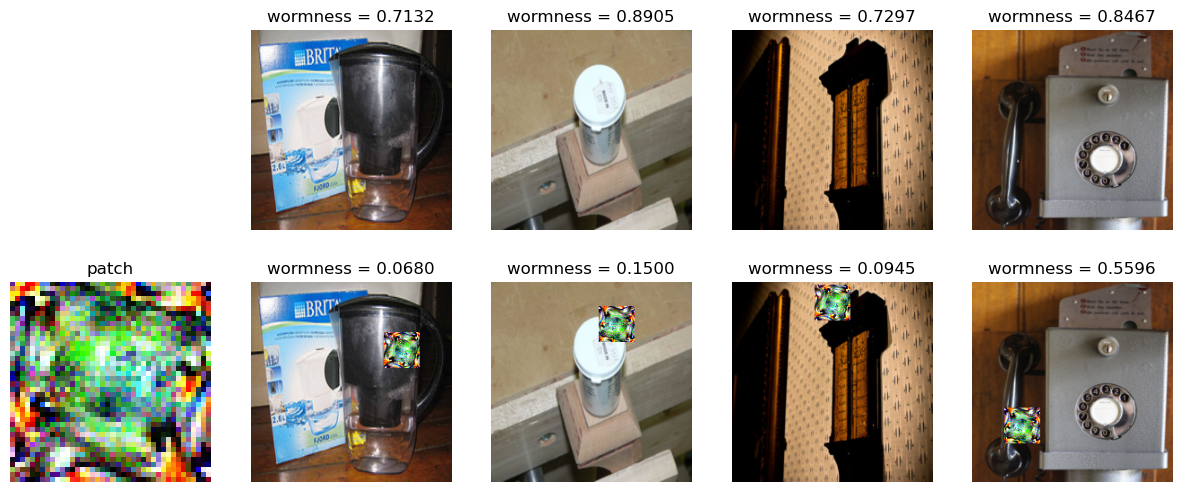

In [8]:
f, axarr = plt.subplots(2,5,figsize=(15, 6))

plt.axis('off')

axarr[0, 0].set_xticks([])
axarr[0, 0].set_yticks([])
axarr[0, 0].set_frame_on(False)
axarr[1, 0].set_xticks([])
axarr[1, 0].set_yticks([])
axarr[1, 0].set_frame_on(False)
axarr[1, 0].set_title(f"patch")
axarr[1, 0].imshow(Image.open("patch.png"))

for i in range(4):
    batch, applied_batch, nopatch, withpatch = results[i]
    i += 1
    axarr[0, i].imshow(tensor_to_img(batch))
    axarr[1, i].imshow(tensor_to_img(applied_batch))

    axarr[0, i].set_xticks([])
    axarr[0, i].set_yticks([])
    axarr[0, i].set_title(f"wormness = {float(nopatch):.4f}")
    axarr[0, i].set_frame_on(False)
    axarr[1, i].set_xticks([])
    axarr[1, i].set_yticks([])
    axarr[1, i].set_title(f"wormness = {float(withpatch):.4f}")
    axarr[1, i].set_frame_on(False)